## 📊 Diabetes Prediction - Model Training

#### 🧰 Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### 📥 Load Dataset

In [ ]:
df = pd.read_csv('../data/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


#### 🧹 Preprocessing - Clean Missing & Zero Values

In [ ]:
cols_to_clean = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_to_clean] = df[cols_to_clean].replace(0, np.nan)
df.fillna(df.mean(), inplace=True)
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

#### 📊 Exploratory Data Analysis (EDA)

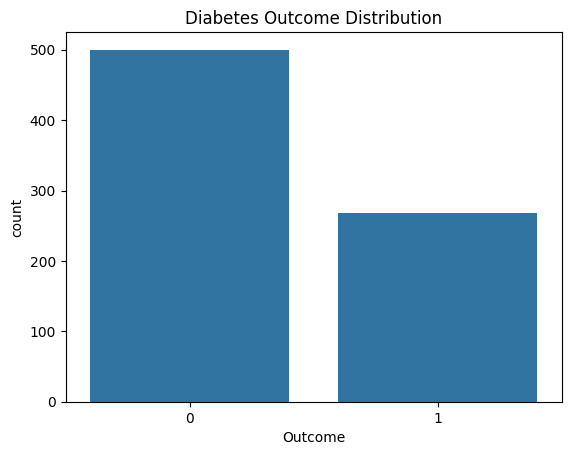

In [ ]:
sns.countplot(x='Outcome', data=df)
plt.title('Diabetes Outcome Distribution')
plt.show()

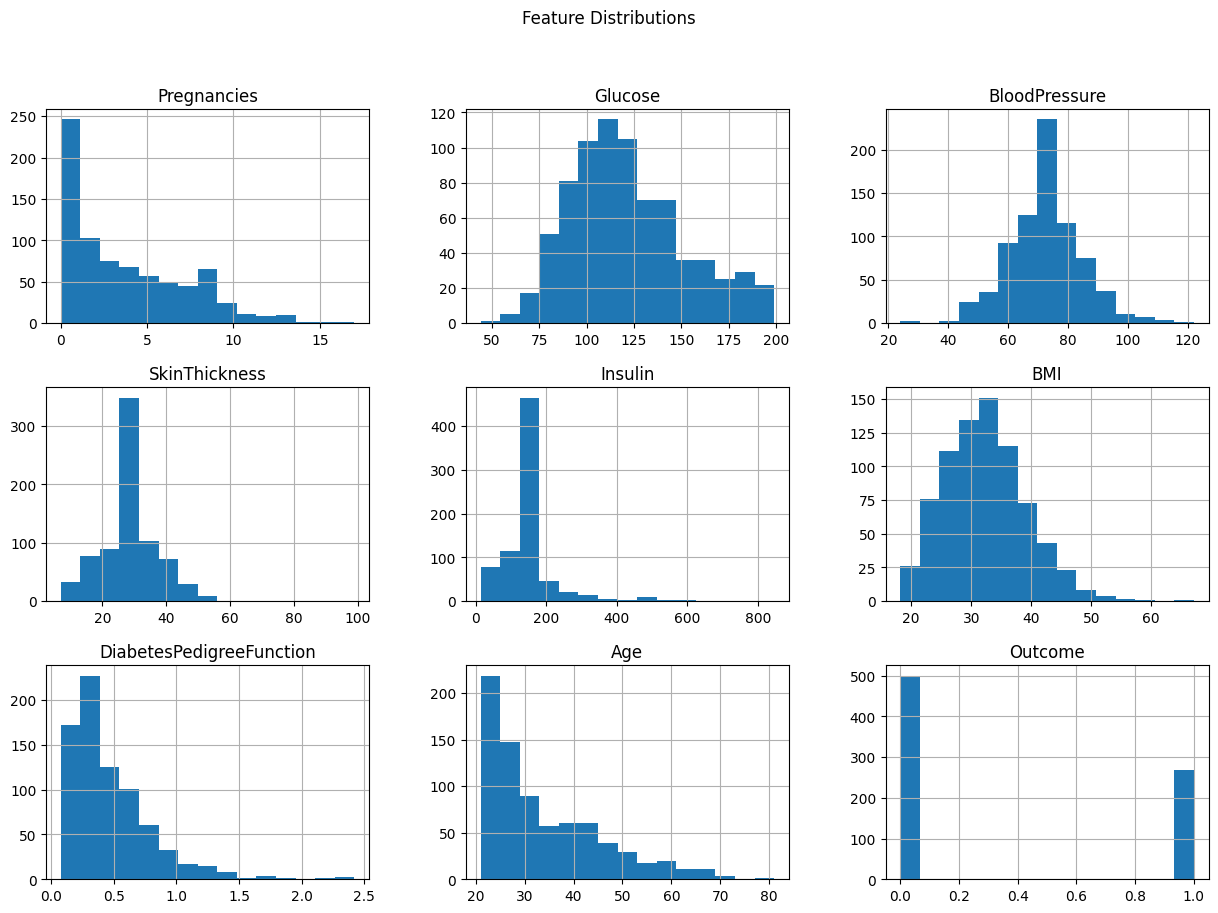

In [ ]:
df.hist(bins=15, figsize=(15, 10))
plt.suptitle("Feature Distributions")
plt.show()

#### 📌 Correlation Matrix

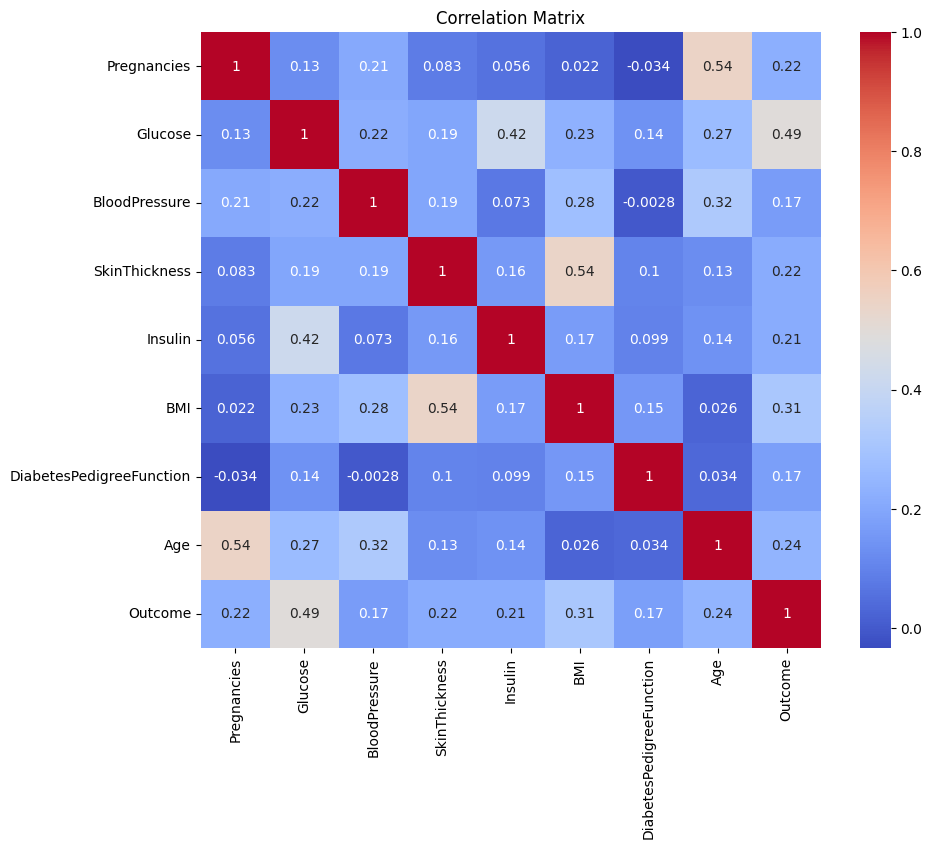

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### ⚠️ Outlier Detection using Z-Score

In [ ]:
from scipy import stats

z_scores = np.abs(stats.zscore(df.drop('Outcome', axis=1)))
df = df[(z_scores < 3).all(axis=1)]
df.shape

(719, 9)

#### 🔄 Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(df.drop('Outcome', axis=1))
y = df['Outcome']

#### 🤖 Train the XGBoost Model

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

c:\Users\Ranjana\Diabetes-Prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:58:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


#### ✅ Evaluation Metrics

              precision    recall  f1-score   support

           0       0.88      0.79      0.83       107
           1       0.53      0.70      0.60        37

    accuracy                           0.76       144
   macro avg       0.71      0.74      0.72       144
weighted avg       0.79      0.76      0.77       144



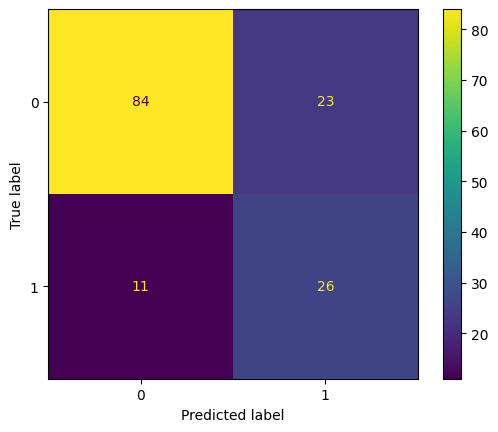

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

#### 🔁 Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("CV Accuracy Scores:", scores)
print("Mean CV Accuracy:", scores.mean())

c:\Users\Ranjana\Diabetes-Prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:58:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ranjana\Diabetes-Prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:58:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ranjana\Diabetes-Prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:58:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


CV Accuracy Scores: [0.72916667 0.72916667 0.72222222 0.75       0.71328671]
Mean CV Accuracy: 0.7287684537684538


c:\Users\Ranjana\Diabetes-Prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:58:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ranjana\Diabetes-Prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:58:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


#### 🔍 SHAP - Explainable AI

c:\Users\Ranjana\Diabetes-Prediction\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


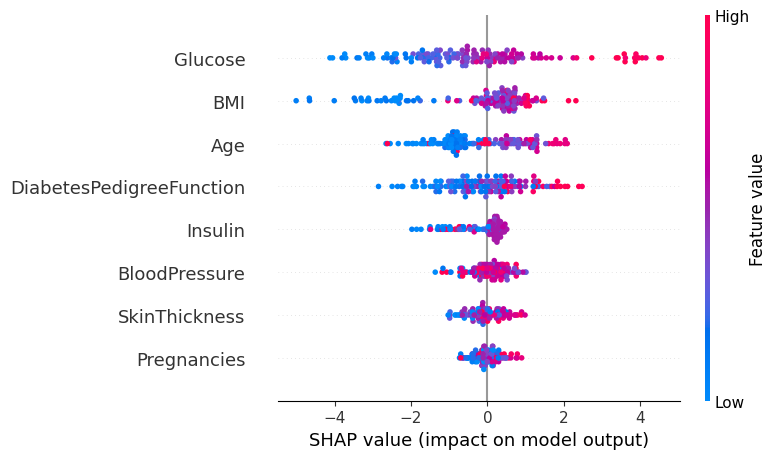

In [ ]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=df.drop('Outcome', axis=1).columns)

#### 💾 Save Model and Scaler

In [ ]:
import joblib

joblib.dump(model, '../models/model.pkl')
joblib.dump(scaler, '../models/scaler.pkl')
print("Model and scaler saved to '../models/'")

Model and scaler saved to '../models/'
